# RECESSION RISK PREDICTION - DAILY

Aiming to anticipate the next recession in the US economy, data from government bonds yield curve and investment-grade corporate bonds spread is used to approximate the recession risk probability introduced in 
[Recession Risk and the Excess Bond Premium](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/recession-risk-and-the-excess-bond-premium-20160408.html).

Click [here](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/files/ebp_csv.csv) to download the updated recession risk indicator.


## FEDS Method


### Corporate Bond Credit Spread

<p style="text-align: center;">
$S^{GZ}_t = \frac{1}{N} \Sigma_i \Sigma_k S_{i,t}[k]$
</p>

where $N_t$ denotes the number of bonds in month $t$ and $S_{i,t}[k]$ is the spread of bond $k$ (a security that is a liability of firm $i$) in month $y$

### Excess Bond Premium (EBP)

<p style="text-align: center;">
$EBP_t = S^{GZ}_t - \hat{S}^{GZ}_t$
<p style="text-align: center;">

Where $\hat{S}^{GZ}_t$ is the corporate bond spread after removing expected default risk of individual firms.

### Probability of Recession Risk

<p style="text-align: center;">
$ P({NBER}_{t, t+12} = 1) = \Phi( \alpha + \beta_1 S^{GS}_t + \gamma_1 TS_t + \gamma_2 RFF_t)$
</p>

Where $S^{GZ}_t$ is the GZ credit spread, $TS_t$ is the term spread and $RFF_t$ is the real funds rate.

Applying the EBP to the previous equation results in 

<p style="text-align: center;">
$ P({NBER}_{t, t+12} = 1) = \Phi( \alpha + \beta_1 \hat{S}^{GS}_t + \beta_2 EBP_t + \gamma_1 TS_t + \gamma_2 RFF_t)$
</p>

\** NBER = National Bureau of Economic Research 

## Proposed Method
The $GZ$ corporate bond spread is approximated as

<p style="text-align: center;">
$S^{GZ}_t \approx A^{GZ}_t + B^{GZ}_t$
</p>

Where $A^{GZ}_t$ is extracted from **CSI A Index** and $A^{GZ}_t$ from **CSI BBB Index**, both indices provided by Bloomberg.

The proposed model for probability of recession risk is presented as the following function

<p style="text-align: center;">
$ P({NBER}) = w_1 A^{GZ}_t + w_2 B^{GZ}_t + w_3 TS_t + w_1 RFF_t$
</p>

 
 

Loading input data
Training models
Training model 0 at iteration 0
Training model 1 at iteration 0
Training model 2 at iteration 0
Computing predictions
Plotting figures


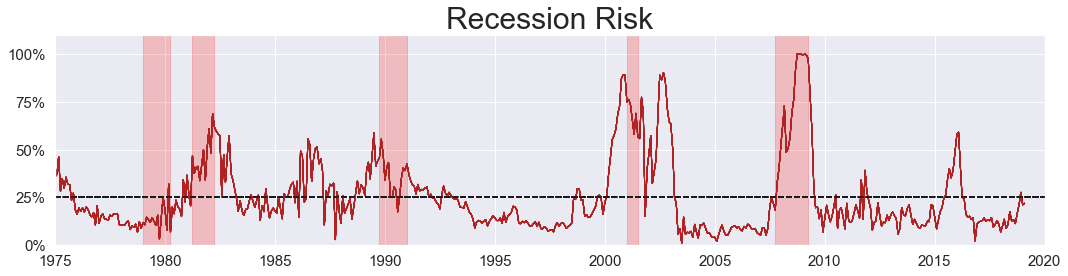

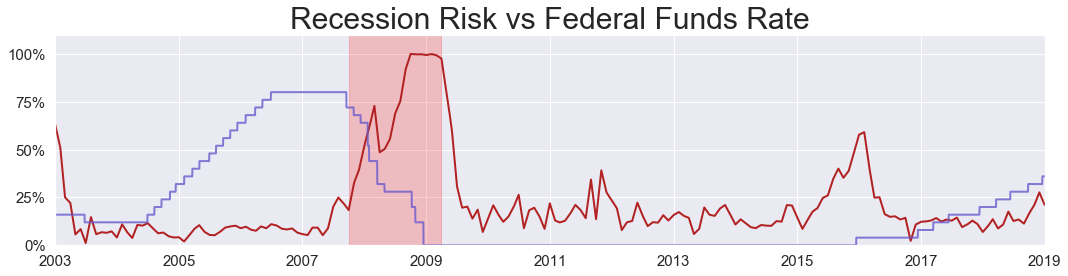

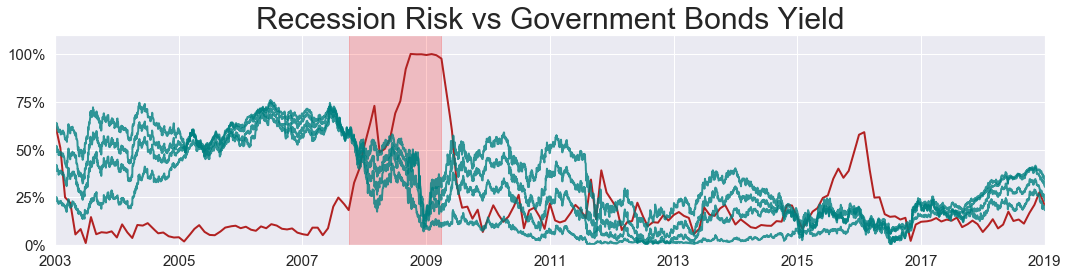

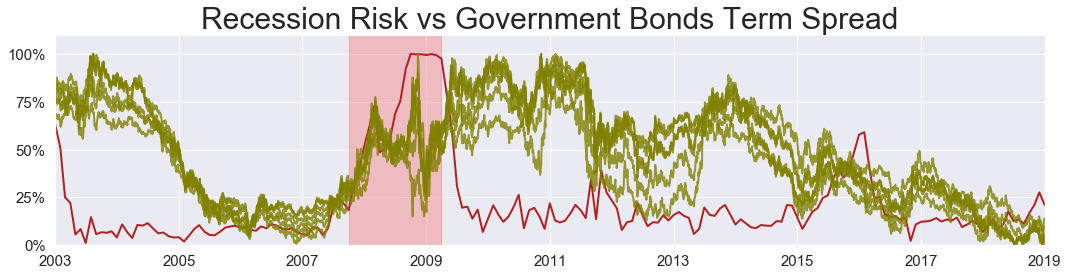

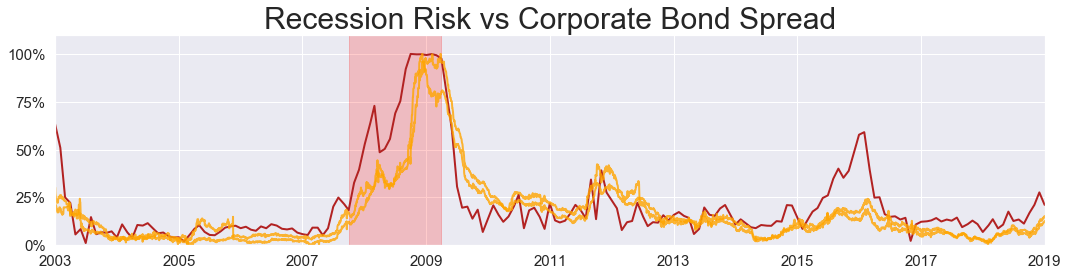

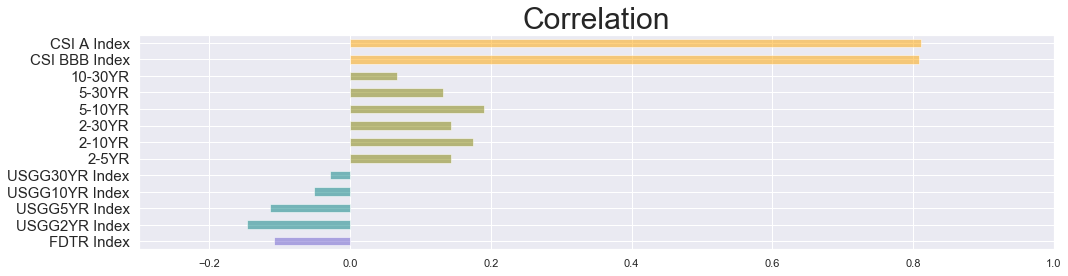

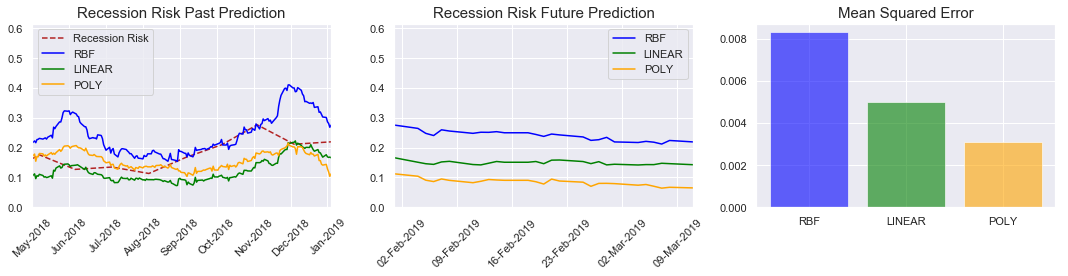

Writing output
Process completed


In [2]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns;

sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import docx
from docx import Document
from docx.shared import Inches
from docx.enum.dml import MSO_THEME_COLOR_INDEX
from docx.enum.text import WD_ALIGN_PARAGRAPH


_input_dir = u'.\Input'
_figures_dir = u'.\Figures'
_output_dir = u'.\Output'

_feds_recs_prob_filename = 'ebp_csv.csv'
_recs_historical_filename = 'recession_data.csv'
_input_data_filename = 'recession_risk_input_data.xls'
_prediction_period = 252  # (days)
_initial_date = '03-01-2000'

# Dates
_ylim = [0, 1.1]
_yticks = [0, 0.25, 0.50, 0.75, 1]
_yticks_label = [str(int(i * 100)) + '%' for i in _yticks]
_figsize = (15, 4)

# Date parser
dateparse = lambda dates: [pd.datetime.strptime(d, '%m/%d/%Y') for d in dates]


# Normalize data
def scale(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())


class Model:
    def __init__(self, k, svr, label):
        self.svr = svr
        self.pred = {}
        self.mse = np.zeros((k, 1))
        self.label = label


class Data:
    def __init__(self, features, target):
        self.features = features
        self.target = target


def get_dates(df, idxs):
    return [df.index[idx].strftime('%m/%d/%Y') for idx in idxs]


def get_train_test_dates(df, test_period=_prediction_period):
    test_dates = get_dates(df, [-test_period, -1])
    train_dates = get_dates(df, [0, -(test_period + 1)])
    return train_dates, test_dates


def get_dataset(features, target, dates):
    # df = merge_data([features[dates[0]:dates[1]], target[dates[0]:dates[1]]])
    return Data(features[dates[0]:dates[1]], target[dates[0]:dates[1]])
    # return Data(features.loc[df.index], target.loc[df.index])


def get_models_args():
    return [{'kernel': 'rbf', 'C': 1e3, 'gamma': 0.1},
            {'kernel': 'linear', 'C': 1e3},
            {'kernel': 'poly', 'C': 1e3, 'degree': 2}]


def initialize_model(mdl_arg, k=1):
    return Model(k, SVR(**mdl_arg), mdl_arg['kernel'].upper())


def initialize_models(mdl={}):
    return [initialize_model(mdl_arg) for mdl_arg in get_models_args()]


def split_data_iloc(features, target, train_idx, test_idx):
    train_data = Data(features.iloc[train_idx], target.iloc[train_idx])
    test_data = Data(features.iloc[test_idx], target.iloc[test_idx])
    return train_data, test_data


def split_data_loc(features, target, train_idx, test_idx):
    train_data = Data(features.iloc[train_idx], target.iloc[train_idx])
    test_data = Data(features.iloc[test_idx], target.iloc[test_idx])
    return train_data, test_data


def kfold_iteration(kfold, mdl, features, target):
    k = 0
    for train_idx, test_idx in kfold.split(features.index):
        train_data, test_data = split_data_iloc(features, target, train_idx, test_idx)
        mdl = train_svr(mdl, train_data, test_data, k)
        k += 1
    return mdl


def kfold_validation(k, features, targets):
    kfold = KFold(k, False, 1)
    mdl = initialize_models()
    mdl = kfold_iteration(kfold, mdl, features, target)
    return mdl


def get_predictions(mdl, test_data):
    preds = pd.DataFrame(mdl.svr.predict(test_data.features))
    preds.index = test_data.target.index
    return preds


def get_future_preds(mdl, features):
    if len(features) > 1:
        for m in mdl:
            m.preds = pd.DataFrame(m.svr.predict(features))


def get_future_pred_summary(mdl):
    df = merge_data([m.pred for m in mdl])
    df.columns = [m.label for m in mdl]
    return df


def get_future_preds(mdl, features):
    if len(features) > 1:
        for m in mdl:
            #            m.pred = {}
            m.pred = pd.DataFrame(m.svr.predict(features))
            m.pred.index = features.index
        return get_future_pred_summary(mdl)
    else:
        return null


def get_pred_summary(mdl):
    df = merge_data([m.pred[0][0] for m in mdl])
    df.columns = [m.label for m in mdl]
    return df


def get_mse(label, pred):
    return round(mean_squared_error(label, pred), 4)


def update_mse(label, mdl):
    return [get_mse(label, m.pred[0]) for m in mdl]


def train_svr(mdl, train_data, test_data, k=0):
    for idx in range(0, len(mdl)):
        print('Training model ' + str(idx) + ' at iteration ' + str(k))
        df = merge_data([train_data.features, train_data.target])
        mdl[idx].svr.fit(train_data.features.loc[df.index], np.ravel(train_data.target.loc[df.index]))
        mdl[idx].pred[k] = get_predictions(mdl[idx], test_data)
        mdl[idx].mse[k] = get_mse(test_data.target, mdl[idx].pred[k])
    return mdl


def resample_daily(df, method='linear'):
    return df.resample('D').interpolate(method)


def load_feds_recs_prob_args():
    return {'filepath_or_buffer': _feds_recs_prob_filename, 'parse_dates': True, 'index_col': 'date',
            'usecols': ['date', 'est_prob']}


def load_feds_recs_prob():
    df = pd.read_csv(**load_feds_recs_prob_args())
    df.columns = ['Recession Risk']
    # return resample_daily(df[_initial_date:])
    return resample_daily(df)


def load_recs_hostorical_args():
    return {'filepath_or_buffer': _recs_historical_filename, 'parse_dates': ['Start', 'End']}


def load_recs_historical():
    return pd.read_csv(**load_recs_hostorical_args())


def load_govt_bonds_yield_args():
    return {'io': _input_data_filename, 'skiprows': 3, 'parse_dates': True, 'index_col': 0, 'usecols': [0, 1, 2, 3, 4]}


def load_govt_bonds_yield():
    df = pd.read_excel(**load_govt_bonds_yield_args())
    return scale(resample_daily(df.dropna()))


def load_term_spread(gby):
    df = pd.DataFrame(gby['USGG5YR Index'] - gby['USGG2YR Index'], columns=['2-5YR'])
    df['2-10YR'] = gby['USGG10YR Index'] - gby['USGG2YR Index']
    df['2-30YR'] = gby['USGG30YR Index'] - gby['USGG2YR Index']
    df['5-10YR'] = gby['USGG10YR Index'] - gby['USGG5YR Index']
    df['5-30YR'] = gby['USGG30YR Index'] - gby['USGG5YR Index']
    df['10-30YR'] = gby['USGG30YR Index'] - gby['USGG10YR Index']
    return scale(df)


def load_corp_bonds_spread_args():
    return {'io': _input_data_filename, 'skiprows': 3, 'parse_dates': True, 'index_col': 0, 'usecols': [0, 5, 6]}


def load_corp_bonds_spread():
    df = pd.read_excel(**load_corp_bonds_spread_args())
    return scale(resample_daily(df.dropna()))


def load_real_funds_rate_args():
    return {'io': _input_data_filename, 'skiprows': 3, 'parse_dates': True, 'index_col': 0, 'usecols': [0, 7]}


def load_real_funds_rate():
    df = pd.read_excel(**load_real_funds_rate_args())
    return scale(resample_daily(df.dropna()))


def merge_data(dfs):
    return pd.concat(dfs, axis=1).dropna()


def get_correlation(dfs):
    return merge_data(dfs).corr()


# Plot recessions
def plot_recs(recs_d, ax, r=None, lim=0):
    for j in recs_d.index:
        start = mdates.date2num(recs_d.iloc[j, 1])
        end = mdates.date2num(recs_d.iloc[j, 2])
        rect = Rectangle((start, -1), end - start, 20, color='red', alpha=0.2)
        ax.add_patch(rect)
        if r is not None:
            ax.plot(r, c='firebrick', linewidth=1, alpha=0.8)
        if lim:
            ax.axhline(y=lim, color='k', linestyle='--')
    return ax


# Plot FEDs recession risk prediction
def plot_recession_risk(recs_d, recs_r):
    fig, ax = plt.subplots(figsize=_figsize)
    plot_recs(recs_d, ax, recs_r, lim=0.25)
    ax.set_xlim(['1975', '2020'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Recession Risk', fontsize=30)
    plt.tight_layout()
    plt.savefig('f1_recession_risk.png')
    #plt.close(fig)
    plt.show()


# Plot Input Data Summary
def plot_input_data_summary(recs_r, recs_d, GBY, CBS, RFF):
    fig, ax = plt.subplots(1, 1, figsize=_figsize)

    # Recession risk
    plt.scatter(recs_r.iloc[:].dropna().index,
                [CBS.shape[1] + GBY.shape[1] + RFF.shape[1]] * recs_r.iloc[:].dropna().shape[0], color='firebrick',
                s=500, alpha=0.5)

    # US Federal Funds Rate
    plt.scatter(RFF.iloc[:].dropna().index, [CBS.shape[1] + GBY.shape[1]] * RFF.iloc[:].dropna().shape[0],
                color='slateblue', s=500, alpha=0.5)

    # US government bonds yield
    for i in range(0, GBY.shape[1]):
        plt.scatter(GBY.iloc[:, i].dropna().index, [CBS.shape[1] + i] * GBY.iloc[:, i].dropna().shape[0], color='teal',
                    s=500, alpha=0.5)

    # Corporate bonds
    for i in range(0, CBS.shape[1]):
        plt.scatter(CBS.iloc[:, i].dropna().index, [i] * CBS.iloc[:, i].dropna().shape[0], color='darkorange', s=500,
                    alpha=0.5)

    plot_recs(recs_d, ax)
    labels = CBS.columns.tolist() + GBY.columns.tolist() + RFF.columns.tolist() + ['Recession Risk']
    plt.yticks(range(0, CBS.shape[1] + GBY.shape[1] + RFF.shape[1] + 1), labels, fontsize=20)
    xlim = ['1972', '2020']
    ylim = [-1, CBS.shape[1] + GBY.shape[1] + RFF.shape[1] + 1]
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(fontsize=20)
    plt.title('Available Data', fontsize=30)
    plt.tight_layout()
    plt.savefig('f2_input_data_summary.png')
    #plt.close(fig)
    plt.show()


# Plot Recession Risk Vs Real Funds Rates
def plot_recs_d_vs_rff(recs_r, recs_d, RFF):
    fig, ax = plt.subplots(figsize=_figsize)
    ax.plot(recs_r, linewidth=2, color='firebrick')
    ax.plot(RFF, linewidth=2, color='slateblue', alpha=0.8)
    plot_recs(recs_d, ax)
    ax.set_xlim(['2003', '2019'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Recession Risk vs Federal Funds Rate', fontsize=30)
    plt.tight_layout()
    plt.savefig('f3_recs_r_vs_rff.png')
    #plt.close(fig)
    plt.show()


# Plot Recession Risk Vs Government Bonds Yield
def plot_recs_d_vs_gby(recs_r, recs_d, GBY):
    fig, ax = plt.subplots(figsize=_figsize)
    ax.plot(recs_r, linewidth=2, color='firebrick')
    ax.plot(GBY, linewidth=2, color='teal', alpha=0.8)
    plot_recs(recs_d, ax)
    ax.set_xlim(['2003', '2019'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Recession Risk vs Government Bonds Yield', fontsize=30)
    plt.tight_layout()
    plt.savefig('f4_recs_r_vs_gby.png')
    #plt.close(fig)
    plt.show()


# Plot Recession Risk Vs Government Bonds Term Spread
def plot_recs_d_vs_ts(recs_r, recs_d, TS):
    fig, ax = plt.subplots(figsize=_figsize)
    ax.plot(recs_r, linewidth=2, color='firebrick')
    ax.plot(TS, linewidth=2, color='olive', alpha=0.8)
    plot_recs(recs_d, ax)
    ax.set_xlim(['2003', '2019'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Recession Risk vs Government Bonds Term Spread', fontsize=30)
    plt.tight_layout()
    plt.savefig('f5_recs_r_vs_ts.png')
    #plt.close(fig)
    plt.show()


# Plot Recession Risk Vs Corporate Bonds Spread
def plot_recs_d_vs_cbs(recs_r, recs_d, CBS):
    fig, ax = plt.subplots(figsize=_figsize)
    ax.plot(recs_r, linewidth=2, color='firebrick')
    ax.plot(CBS, linewidth=2, color='orange', alpha=0.8)
    plot_recs(recs_d, ax)
    ax.set_xlim(['2003', '2019'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Recession Risk vs Corporate Bond Spread', fontsize=30)
    plt.tight_layout()
    plt.savefig('f6_recs_r_vs_cbs.png')
    #plt.close(fig)
    plt.show()


# Plot Correlation Between Variables
def plot_correlation(corr):
    color = ['slateblue', 'teal', 'teal', 'teal', 'teal', 'olive', 'olive', 'olive', 'olive', 'olive', 'olive',
             'orange', 'orange']
    corr.iloc[0, 1:].plot.barh(color=color, alpha=0.5, xlim=(-0.3, 1), figsize=_figsize)
    plt.yticks(fontsize=15)
    plt.title('Correlation', fontsize=30)
    plt.tight_layout()
    plt.savefig('f7_correlation.png')
    #plt.close()
    plt.show()


# Plot K-Fold Results
def plot_kfold_mse(mdl):
    fig, ax = plt.subplots(1, len(mdl), figsize=_figsize)
    for i in range(0, len(mdl)):
        ax[i].plot(mdl[i].mse)
        ax[i].set_title(mdl[i].label + ', K=' + str(k) + ', MSE=' + str(np.mean(mdl[i].mse).round(4)), fontsize=15)
        ax[i].set_ylim(0, 0.15)
        ax[i].set_xticks([])
        plt.tight_layout()
    plt.savefig('f8_kfold_result.png')
    #plt.close(fig)
    plt.show()


# Plot Input Data
def plot_input_data(recs_r, recs_d, GBY, CBS, RFF):
    fig, ax = plt.subplots(figsize=_figsize)
    ax.plot(recs_r, linewidth=2, color='firebrick')
    ax.plot(RFF, linewidth=2, color='slateblue', alpha=0.5)
    ax.plot(GBY, linewidth=2, color='teal', alpha=0.5)
    ax.plot(TS, linewidth=2, color='olive', alpha=0.5)
    ax.plot(CBS, linewidth=2, color='orange', alpha=0.8)

    # ax.set_xlim(['2003', '2019'])
    ax.set_ylim([0, 1.1])
    plt.xticks(fontsize=15)
    plt.yticks(_yticks, _yticks_label, fontsize=15)
    plt.title('Input Data', fontsize=30)

    start = mdates.date2num(datetime.strptime(test_dates[0], '%m/%d/%Y'))
    end = mdates.date2num(datetime.strptime(test_dates[1], '%m/%d/%Y'))
    rect = Rectangle((start, -1), end - start, 20, color='green', alpha=0.2)
    ax.add_patch(rect)

    start = mdates.date2num(datetime.strptime(train_dates[0], '%m/%d/%Y'))
    end = mdates.date2num(datetime.strptime(train_dates[1], '%m/%d/%Y'))
    rect = Rectangle((start, -1), end - start, 20, color='orange', alpha=0.2)
    ax.add_patch(rect)
    plt.tight_layout()
    plt.savefig('f9_input_data.png')
    #plt.close(fig)
    plt.show()


def plot_recs_r_prediction(recs_r, mdl, past_preds, future_preds):
    fig, ax = plt.subplots(1, 3, figsize=_figsize)
    color = ['firebrick', 'blue', 'green', 'orange']
    ax[0].plot(recs_r, '--', color=color[0])
    for i, col in enumerate(past_preds.columns):
        ax[0].plot(past_preds[col], color=color[i + 1])
    ax[0].set_ylim(0, past_preds.max().max() * 1.5)
    ax[0].set_xlim([past_preds.index[0], past_preds.index[-1]])
    ax[0].legend(recs_r.columns.tolist() + past_preds.columns.tolist())
    ax[0].set_title('Recession Risk Past Prediction', fontsize=15)
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=31))
    ax[0].xaxis.set_tick_params(rotation=45)

    for i, col in enumerate(future_preds.columns):
        ax[1].plot(future_preds[col], color=color[i + 1])
    ax[1].set_ylim(0, past_preds.max().max() * 1.5)
    ax[1].set_xlim([past_preds.index[0], past_preds.index[-1]])
    ax[1].legend(future_preds.columns.tolist())
    ax[1].set_title('Recession Risk Future Prediction', fontsize=15)
    ax[1].set_xlim([future_preds.index[0], future_preds.index[-1]])
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax[1].xaxis.set_tick_params(rotation=45)

    for i, m in enumerate(mdl):
        ax[2].bar(i + 1, m.mse[0], color=color[i + 1], alpha=0.6)
    plt.xticks((1, 2, 3), (past_preds.columns))
    ax[2].set_title('Mean Squared Error', fontsize=15)
    plt.tight_layout()
    plt.savefig('f10_recs_r_prediction.png')
    #plt.close(fig)
    plt.show()


def load_data():
    os.chdir(_input_dir)

    # Recession risk
    recs_r = load_feds_recs_prob()

    # Recession labels
    recs_d = load_recs_historical()

    # US government bonds yield
    GBY = load_govt_bonds_yield()

    # Term Spread (yield difference between government bonds)
    TS = load_term_spread(GBY)

    # US investment grade corporate bonds spread
    CBS = load_corp_bonds_spread()

    # US Federal Funds Rate
    RFF = load_real_funds_rate()

    return recs_r, recs_d, GBY, TS, CBS, RFF


def plot_figures(recs_r, recs_d, GBY, TS, CBS, RFF, corr, mdl, past_predictions, future_predictions):
    os.chdir(_figures_dir)
    plot_recession_risk(recs_d, recs_r)
    # plot_input_data_summary(recs_r, recs_d, GBY, CBS, RFF)
    plot_recs_d_vs_rff(recs_r, recs_d, RFF)
    plot_recs_d_vs_gby(recs_r, recs_d, GBY)
    plot_recs_d_vs_ts(recs_r, recs_d, TS)
    plot_recs_d_vs_cbs(recs_r, recs_d, CBS)
    plot_correlation(corr)
    # plot_input_data(recs_r, recs_d, GBY, CBS, RFF)
    plot_recs_r_prediction(recs_r, mdl, past_predictions, future_predictions)


def write_output(past_predictions, future_predictions, recs_r):
    
    # Change to output directory
    os.chdir(_output_dir)
    
    # Write excel output
    write_excel_output(past_predictions, future_predictions, recs_r)
    
    # Write word output
    write_word_output(past_predictions, future_predictions, recs_r)

def write_excel_output(past_predictions, future_predictions, recs_r):
    _output_file = 'RecessionRiskPrediction_' + datetime.today().strftime('%Y%m%d') + '.xlsx'
    with pd.ExcelWriter(_output_file, datetime_format='dd-mm-yyyy') as writer:
        
        # Write prediction summary
        pd.DataFrame().to_excel(writer, sheet_name='Prediction Summary')
        workbook = writer.book
        worksheet = writer.sheets['Prediction Summary']
        worksheet.insert_image('A1', '../Figures/f10_recs_r_prediction.png')

        # Write past prediction
        format1 = workbook.add_format({'num_format': '#,##0.00'})
        past_predictions = merge_data([recs_r, past_predictions])
        past_predictions.to_excel(writer, sheet_name='Past Predictions')
        worksheet = writer.sheets['Past Predictions']
        worksheet.set_column('A:E', 20, format1)

        # Write future prediction
        future_predictions.to_excel(writer, sheet_name='Future Predictions')
        worksheet = writer.sheets['Future Predictions']
        worksheet.set_column('A:D', 20, format1)

        # Write input data
        # pd.DataFrame().to_excel(writer, sheet_name='Input Data')
        # workbook = writer.book
        # worksheet = writer.sheets['Input Data']
        # worksheet.insert_image('A1', './Figures/f3_recs_r_vs_rff.png')

        writer.save()

        
def add_hyperlink(paragraph, text, url):
    # This gets access to the document.xml.rels file and gets a new relation id value
    part = paragraph.part
    r_id = part.relate_to(url, docx.opc.constants.RELATIONSHIP_TYPE.HYPERLINK, is_external=True)

    # Create the w:hyperlink tag and add needed values
    hyperlink = docx.oxml.shared.OxmlElement('w:hyperlink')
    hyperlink.set(docx.oxml.shared.qn('r:id'), r_id, )

    # Create a w:r element and a new w:rPr element
    new_run = docx.oxml.shared.OxmlElement('w:r')
    rPr = docx.oxml.shared.OxmlElement('w:rPr')

    # Join all the xml elements together add add the required text to the w:r element
    new_run.append(rPr)
    new_run.text = text
    hyperlink.append(new_run)

    # Create a new Run object and add the hyperlink into it
    r = paragraph.add_run ()
    r._r.append (hyperlink)

    # A workaround for the lack of a hyperlink style (doesn't go purple after using the link)
    # Delete this if using a template that has the hyperlink style in it
    r.font.color.theme_color = MSO_THEME_COLOR_INDEX.HYPERLINK
    r.font.underline = True

    return hyperlink


def write_word_output(past_predictions, future_predictions, recs_r):
    
    # Change to output directory
    os.chdir(_output_dir)
    
    _output_file = 'RecessionRiskPrediction_' + datetime.today().strftime('%Y%m%d') + '.docx'
    _feds_url = 'https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/recession-risk-and-the-excess-bond-premium-20160408.html'
    _FEDS_last_date = recs_r.tail(1).index.strftime('%d-%m-%Y').values[0]
    _last_date = future_predictions.tail(1).index.strftime('%d-%m-%Y').values[0]
    _figure_size = (6,1.9)
    document = Document()

    p = document.add_heading('Recession Risk Prediction', 0)
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER # for left, 1 for right, 2 center, 3 justify ....
    
    p = document.add_paragraph('Aiming to anticipate the next recession in the US economy, data from government bonds yield curve and investment-grade corporate bonds spread is used to approximate the recession risk probability introduced in ')
    add_hyperlink(p, 'Recession Risk and the Excess Bond Premium', _feds_url)
    p.add_run('.')
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    
    document.add_heading('FED\'s Recession Risk and the Excess Bond Premium', level=1)
    p = document.add_paragraph('The official prediction for recession risk is published on a monthly basis and is presented in the following figured updated to ')
    p.add_run(_FEDS_last_date)
    p.add_run('.')
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    
    document.add_picture('../Figures/f1_recession_risk.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))

    document.add_heading('Ostrica\'s Recession Risk Prediction', level=1)
    p = document.add_paragraph('Our predictive model makes use of corporate bonds spread, government bonds yields and real fund rates to predict the recession risk. The information used is presented below. ')
    document.add_picture('../Figures/f6_recs_r_vs_cbs.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))
    document.add_picture('../Figures/f4_recs_r_vs_gby.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))
    document.add_picture('../Figures/f5_recs_r_vs_ts.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))
    document.add_picture('../Figures/f3_recs_r_vs_rff.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    
    p = document.add_paragraph('The informative value of each component can be assessed by their correlation (negative or positve) to the published recession risk prediction.')
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    document.add_picture('../Figures/f7_correlation.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))

    document.add_heading('Current Predictions', level=1)
    p = document.add_paragraph('Three candidate models are trained to predict the recession risk: RBF, LINEA and POLY. ')
    p.add_run('Comparing FED\'s prediction to our model over the past ')
    p.add_run(str(_prediction_period))
    p.add_run(' days confirms the accuracy of our models as seen from figure "Recession Risk Past Prediction". ')
    p.add_run('In figure "Recession Risk Future Prediction" we present our prediction for recession risk in advance to the FED\'S official prediction. ')
    p.add_run('The measure of error between our candidate models and FED\'S official prediction can be seen in figure "Mean Square Error".')
    document.add_picture('../Figures/f10_recs_r_prediction.png', width=Inches(_figure_size[0]), height=Inches(_figure_size[1]))
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    
    p = document.add_paragraph('As of ')
    p.add_run(_last_date)
    p.add_run(' the mean prediction of our models for recession risk is at ')
    p.add_run(str(round(future_predictions.iloc[-1].mean()*100,2)))
    p.add_run('%.')
    document.save(_output_file)
        
def main():

    # Load Data
    print('Loading input data')
    recs_r, recs_d, GBY, TS, CBS, RFF = load_data()

    # Correlation among variables
    corr = get_correlation([recs_r, RFF, GBY, TS, CBS])

    features = merge_data([RFF, GBY, TS, CBS])
    target = recs_r

    train_dates, test_dates = get_train_test_dates(merge_data([features, target]), _prediction_period)

    # k-fold validation
    # dates = [train_dates[0],test_dates[1]]
    # mdl = kfold_validation(16, features[dates[0]:dates[1]], target[dates[0]:dates[1]])
    # plot_kfold_mse(mdl)

    # Recession Risk Prediction
    print('Training models')
    train_data = get_dataset(features, target, train_dates)
    test_data = get_dataset(features, target, test_dates)

    # Initialize models
    mdl = initialize_models()

    # Train models
    mdl = train_svr(mdl, train_data, test_data, 0)

    # Get predictions
    print('Computing predictions')
    past_predictions = get_pred_summary(mdl)
    future_predictions = get_future_preds(mdl, features[test_dates[1]:])

    # Plot figures
    print('Plotting figures')
    plot_figures(recs_r, recs_d, GBY, TS, CBS, RFF, corr, mdl, past_predictions, future_predictions)

    print('Writing output')
    write_output(past_predictions, future_predictions, recs_r)

    print('Process completed')


if __name__ == '__main__':
    main()
    